In [2]:
import random

In [135]:
from collections import Counter

In [3]:
import re

In [149]:
import numpy as np
from matplotlib import pyplot as plt

In [5]:
from glob import glob

In [6]:
from pprint import pprint as pp

In [1]:
from parse_tfrecord import get_numbers_list as get_data
from parse_tfrecord import get_labels_list as get_labels
from parse_tfrecord import printkw

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [7]:
labeldict = dict()
uniqlabels = set()
wantlabels = {'Baby laughter','Belly laugh','Female singing','Female speech, woman speaking',
              'Hubbub, speech noise, speech babble','Giggle','Hum','Humming','Laughter','Male singing',
              'Male speech, man speaking','Narration, monologue','Singing','Speech','Vocal music',
              'Whispering','Whistle','Whistling','Yell',}
with open("./class_labels_indices.csv", 'r') as csv:
    csv.readline()
    count = 0
    for line in csv:
        count += 1
        # print(line[:-1])
        
        index = int(line[:-1].split(',')[0])
        code = line[:-1].split(',')[1]
        label = ','.join(line[:-1].split(',')[2:])
        label = re.sub('"', '', label)
        # print(index,code,label,'\n')
        
        labeldict[index] = label
        labeldict[label] = index
        labeldict[code] = index
        uniqlabels.add(label)
wantindex = set([labeldict[s] for s in wantlabels])
pp(wantindex)

{0, 33, 32, 1, 2, 37, 70, 5, 40, 11, 15, 496, 16, 18, 402, 17, 20, 27, 254}


In [126]:
one_hot = dict()
for i, ind in enumerate(sorted(wantindex)):
    one_hot[i] = ind
    one_hot[str(ind)] = i
print(one_hot)

{0: 0, 1: 1, 2: 2, 3: 5, 4: 11, 5: 15, 6: 16, 7: 17, '17': 7, 9: 20, 10: 27, 11: 32, 12: 33, 13: 37, '1': 1, 15: 70, 16: 254, 17: 402, '402': 17, '32': 11, '27': 10, '18': 8, '33': 12, '496': 18, '37': 13, '2': 2, 14: 40, '40': 14, '70': 15, '5': 3, '254': 16, '16': 6, 18: 496, '15': 5, 8: 18, '20': 9, '0': 0, '11': 4}


In [8]:
wantlist = []
otherlist = []
with open("balanced_train_segments.csv") as csv:
    for i, line in enumerate(csv):
        if i < 3: continue
        name = line.split()[0][:-1]
        labels = {labeldict[x] for x in re.sub('"', '', line.split()[3]).split(',')}
        filepath = glob("./audioset_v1_embeddings/bal_train/%s*"%name[-2:])
        if len(filepath):
            if len(labels.intersection(wantindex)):
                wantlist.append(filepath[0])
            else:
                otherlist.append(filepath[0])
        print("%.3f percent done"%(i/220), end='\r')
        # if i >= 100: break

In [9]:
print(len(wantlist), len(otherlist), len(wantlist)+len(otherlist))

6697 15295 21992


In [128]:
def data_gen(slic=slice(0,.8), lis=None, want=True):
    if slic.start == None: slic = slice(0, slic.stop, slic.step)
    slic = slice(int(slic.start*len(lis)),int(slic.stop*len(lis)),slic.step)
    random.shuffle(lis[slic])
    X,Y = [],[]
    for i, filename in enumerate(lis[slic]):
        x = get_data(filename)
        if x.shape[0] != 10: continue
#         print(type(x))
        l = get_labels(filename)
        Yset = set(l)
        if want and not len(Yset.intersection(wantindex)): continue
        elif want: Yset.intersection_update(wantindex)
        if not want and len(Yset.intersection(wantindex)): continue
        for y in Yset:
            y = 1+0*len(wantindex) if (y not in wantindex) else 0#one_hot[str(y)]
            X.append(x)
            Y.append([y]*10)
        print("%.3f percent done"%(i*100/len(lis[slic])), end='\r')
    print()
    return X,Y

In [11]:
wantdata = data_gen(slic=slice(.01), lis=wantlist, want=True)
otherdata = data_gen(slic=slice(.01), lis=otherlist, want=False)

95.455 percent done
98.684 percent done


In [15]:
i = random.randint(0, len(wantdata[0])-1)
printkw() << len(wantdata[0][i])
printkw() << (labeldict[wantdata[1][i]] if wantdata[1][i] in wantindex else None)

10
Whistling


'Whistling'

In [129]:
x1tr,y1tr = data_gen(slic=slice(.8), lis=wantlist, want=True)
x2tr,y2tr = data_gen(slic=slice(.08), lis=otherlist, want=False)
print(len(x1tr),len(x2tr)); print()
train = np.array(x1tr+x2tr),np.array(y1tr+y2tr)

x1,y1 = data_gen(slic=slice(.8,1), lis=wantlist, want=True)
x2,y2 = data_gen(slic=slice(.08,.1), lis=otherlist, want=False)
print(len(x1),len(x2))
test = np.array(x1+x2),np.array(y1+y2)

99.963 percent done
99.918 percent done
1732 1790

99.776 percent done
99.673 percent done
416 421


In [130]:
printkw() << (train[0].shape,train[1].shape)
printkw() << (test[0].shape,test[1].shape)

((3522, 10, 128), (3522, 10))
((837, 10, 128), (837, 10))


((837, 10, 128), (837, 10))

In [131]:
import keras
import keras.backend as K
from keras.layers import Dense, Dropout, LeakyReLU, Flatten, LSTM, Input
from keras.models import Model

In [132]:
input_1 = Input(batch_shape=(None,10,128), name='input_1')
dense_1 = Dense(128, activation='tanh', name='dense_1')(input_1)
dense_2 = Dense(128, activation='relu', name='dense_2')(dense_1)
dense_3 = Dense(64, activation='relu', name='dense_3')(dense_2)
dense_4 = Dense(32, activation='relu', name='dense_4')(dense_3)
dense_5 = Dense(len(wantindex)+1, activation='relu', name='dense_5')(dense_4)
out_1 = Dense(0*len(wantindex)+1+1, activation='softmax', name='out_1')(dense_5)
model = Model(inputs=[input_1], outputs=[out_1])

model.compile(optimizer="adadelta", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 10, 128)           0         
_________________________________________________________________
dense_1 (Dense)              (None, 10, 128)           16512     
_________________________________________________________________
dense_2 (Dense)              (None, 10, 128)           16512     
_________________________________________________________________
dense_3 (Dense)              (None, 10, 64)            8256      
_________________________________________________________________
dense_4 (Dense)              (None, 10, 32)            2080      
_________________________________________________________________
dense_5 (Dense)              (None, 10, 20)            660       
_________________________________________________________________
out_1 (Dense)                (None, 10, 2)             42        
Total para

In [133]:
H1 = model.fit(x=train[0], y=train[1].reshape(-1,10,1), batch_size=16, shuffle=1, epochs=256)

Epoch 1/256
3522/3522 [==============================] - 4s 1ms/step - loss: 0.6782 - acc: 0.5750
Epoch 2/256
3522/3522 [==============================] - 2s 604us/step - loss: 0.6393 - acc: 0.6333
Epoch 3/256
3522/3522 [==============================] - 2s 611us/step - loss: 0.6104 - acc: 0.6654
Epoch 4/256
3522/3522 [==============================] - 2s 609us/step - loss: 0.5853 - acc: 0.6865
Epoch 5/256
3522/3522 [==============================] - 2s 606us/step - loss: 0.5683 - acc: 0.7028
Epoch 6/256
3522/3522 [==============================] - 2s 608us/step - loss: 0.5716 - acc: 0.7012
Epoch 7/256
3522/3522 [==============================] - 2s 608us/step - loss: 0.5571 - acc: 0.7110
Epoch 8/256
3522/3522 [==============================] - 2s 608us/step - loss: 0.5537 - acc: 0.7127
Epoch 9/256
3522/3522 [==============================] - 2s 605us/step - loss: 0.5427 - acc: 0.7244
Epoch 10/256
3522/3522 [==============================] - 2s 602us/step - loss: 0.5322 - acc: 0.7291
E

3522/3522 [==============================] - 2s 603us/step - loss: 0.0779 - acc: 0.9687
Epoch 163/256
3522/3522 [==============================] - 2s 603us/step - loss: 0.0696 - acc: 0.9742
Epoch 164/256
3522/3522 [==============================] - 2s 605us/step - loss: 0.0464 - acc: 0.9824
Epoch 165/256
3522/3522 [==============================] - 2s 603us/step - loss: 0.0518 - acc: 0.9804
Epoch 166/256
3522/3522 [==============================] - 2s 605us/step - loss: 0.0715 - acc: 0.9733
Epoch 167/256
3522/3522 [==============================] - 2s 606us/step - loss: 0.0639 - acc: 0.9762
Epoch 168/256
3522/3522 [==============================] - 2s 607us/step - loss: 0.0768 - acc: 0.9704
Epoch 169/256
3522/3522 [==============================] - 2s 613us/step - loss: 0.0587 - acc: 0.9776
Epoch 170/256
3522/3522 [==============================] - 2s 599us/step - loss: 0.0853 - acc: 0.9670
Epoch 171/256
3522/3522 [==============================] - 2s 609us/step - loss: 0.0727 - acc: 0

In [164]:
ev = model.evaluate(x=test[0], y=test[1].reshape(-1,10,1), batch_size=16)
print(ev)

837/837 [==============================] - 0s 301us/step
[0.28826854982292616, 0.9534050156423552]


In [136]:
y_hats = model.predict_on_batch(x=test[0])
y_hats.shape

(837, 10, 2)

In [142]:
dom_labels = []
for j, pred in enumerate(y_hats):
    c = Counter([np.argmax(pred[i]) for i in range(pred.shape[0])])
    dom_labels.append(c.most_common()[0][0])
print(Counter(dom_labels))

Counter({0: 439, 1: 398})


In [148]:
print(Counter([entry[0] for entry in test[1]]))

Counter({1: 421, 0: 416})


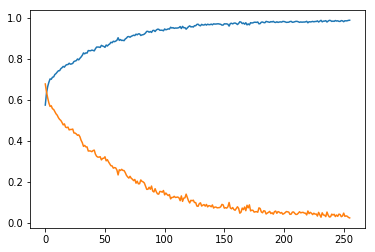

In [159]:
plt.plot(range(len(H1.history['acc'])), H1.history['acc'], H1.history['loss'])
plt.show()

In [166]:
with open("binary_model_config.yml", 'w') as out:
    print(model.to_yaml(), file=out)

In [167]:
model.save_weights("binary_model_weights.h5")

In [97]:
# OLD model with 20 categorical classes
# model.evaluate(x=test[0], y=test[1].reshape(-1,10,1), batch_size=16, )

837/837 [==============================] - 0s 310us/step


[1.0149752393747673, 0.697729985773777]